## Step 1. 准备全局 GGI 网络
确定所有 gene 节点的全集（两列，以空格分割）
___

In [1]:
import os
from tqdm import tqdm
from pathlib import Path

In [2]:
# ===== 根目录路径 =====
DATA_ROOT = Path("/apdcephfs_qy3/share_2932069/ziyiyang/1-antibiotic_resistance/PANACEA/data/3-string_ppi_data")
OUTPUT_ROOT = Path("/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/data/5-network/")

# 输出文件
OUT_FILE = OUTPUT_ROOT / "global_ggi_edgelist.txt"

In [3]:
edges = set()

files = list(DATA_ROOT.rglob("*.ggi.in_genes.tsv"))
print(f"Found {len(files)} files.")

for tsv_path in tqdm(files):
    with tsv_path.open("r", encoding="utf-8", errors="ignore") as f:
        # ---- 跳过表头 ----
        header = next(f, None)
        
        # ---- 逐行读取数据 ----
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split("\t")
            if len(parts) < 2:
                continue

            g1, g2 = parts[0].strip(), parts[1].strip()

            if not g1 or not g2 or g1 == g2:
                continue

            # 无向边
            if g1 < g2:
                edge = (g1, g2)
            else:
                edge = (g2, g1)

            edges.add(edge)

len(edges)

Found 86 files.


100%|██████████| 86/86 [00:01<00:00, 54.18it/s]


139731

In [10]:
with OUT_FILE.open("w", encoding="utf-8") as out:
    for g1, g2 in sorted(edges):
        out.write(f"{g1} {g2}\n")

print(f"Saved global edgelist to:\n{OUT_FILE}")

Saved global edgelist to:
/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/data/5-network/global_ggi_edgelist.txt


In [4]:
! head -n 20 $OUT_FILE

AAH1 ADE12
AAH1 ADE13
AAH1 ADE5,7
AAH1 ADK1
AAH1 ADO1
AAH1 APT1
AAH1 ARX1
AAH1 DAP2
AAH1 DBP2
AAH1 DUT1
AAH1 EAF7
AAH1 FGR23
AAH1 GUA1
AAH1 GUK1
AAH1 HAM1
AAH1 HAS1
AAH1 HPT1
AAH1 HYU1
AAH1 IMH3
AAH1 ISN1


## Step 2. 准备 Meta-graph 网络
构建 GO annotation - Strains 的层级关系
___

In [5]:
from pathlib import Path

GO_ROOT = Path("/apdcephfs_qy3/share_2932069/ziyiyang/1-antibiotic_resistance/PANACEA/data/4-go_annotation")
OUT_FILE = Path("/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/data/5-network/mg_edgelist.txt")
OUT_FILE_ACTIVE = Path("/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/data/5-network/mg_ac_edgelist.txt")

OUT_FILE.parent.mkdir(parents=True, exist_ok=True)

In [6]:
from tqdm import tqdm
import itertools

edges = set()             # (nodeA, nodeB)
species_to_strains = {}   # species → list of strains

strain_dirs = [p for p in GO_ROOT.iterdir() if p.is_dir()]
print(f"Found {len(strain_dirs)} strain folders.")

def get_species_from_folder(folder_name):
    """species 是 去掉最后一个 '_' 之后的部分"""
    if "_" not in folder_name:
        return folder_name
    return "_".join(folder_name.split("_")[:-1])

go_node_list = []
for strain_dir in tqdm(strain_dirs):
    strain_name = strain_dir.name
    species = get_species_from_folder(strain_name)

    # 收集 species → strain
    species_to_strains.setdefault(species, []).append(strain_name)

    # GO edges
    for tsv_path in strain_dir.glob("*.go_raw.tsv"):
        with tsv_path.open("r", encoding="utf-8", errors="ignore") as f:
            next(f, None)  # skip header

            for line in f:
                parts = line.strip().split("\t")
                if len(parts) < 5:
                    continue

                go_id = parts[3].strip()
                go_type = parts[4].strip()

                if not go_id or not go_type:
                    continue

                go_node = f"{go_id}_{go_type}"
                go_node_list.append(go_node)
                strain_name_logo = f"STRAIN:{strain_name}"

                edges.add((go_node, strain_name_logo))  # GO → strain


Found 86 strain folders.


100%|██████████| 86/86 [00:00<00:00, 87.15it/s] 


In [7]:
strain_edges = set()

for species, strain_list in species_to_strains.items():
    if len(strain_list) < 2:
        continue

    # 对每个 species 内的 strain 做两两组合
    for a, b in itertools.combinations(strain_list, 2):
        # 无向边归一化
        edge = tuple(sorted((a, b)))
        strain_edges.add(edge)

len(strain_edges)

1189

In [8]:
# 统一合并：GO-strain edges + strain-strain edges
final_edges = set()

# 添加 GO → strain edges
for a, b in edges:
    final_edges.add((a, b))

In [9]:
# 添加 strain ↔ strain edges
for a, b in strain_edges:
    final_edges.add((a, b))

print("Total edges:", len(final_edges))

Total edges: 73245


In [10]:
# 写出成 tsv 格式
with OUT_FILE.open("w", encoding="utf-8") as out:
    for a, b in sorted(final_edges):
        out.write(f"{a}\t{b}\n")

print("Saved to:", OUT_FILE)

Saved to: /opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/data/5-network/mg_edgelist.txt


## Step 3. 准备 GGI_edgelists
为每个 GO annotation 准备单独的 GGI 网络
____

In [11]:
from pathlib import Path
from collections import defaultdict
import pandas as pd
import re
from tqdm import tqdm

# ===== 路径配置 =====
DATA_ROOT = Path("/apdcephfs_qy3/share_2932069/ziyiyang/1-antibiotic_resistance/PANACEA/data/")

GO_ROOT   = DATA_ROOT / "4-go_annotation"
GGI_ROOT  = DATA_ROOT / "3-string_ppi_data"

# version 1: 无 score
OUT_ROOT1 = DATA_ROOT / "5-network" / "ggi_edgelists"
# version 2: 带 score
OUT_ROOT2 = DATA_ROOT / "5-network" / "ggi_edgelists_with_score"

OUT_ROOT1.mkdir(parents=True, exist_ok=True)
OUT_ROOT2.mkdir(parents=True, exist_ok=True)

print("GO_ROOT :", GO_ROOT)
print("GGI_ROOT:", GGI_ROOT)
print("OUT1:", OUT_ROOT1)
print("OUT2:", OUT_ROOT2)

GO_ROOT : /apdcephfs_qy3/share_2932069/ziyiyang/1-antibiotic_resistance/PANACEA/data/4-go_annotation
GGI_ROOT: /apdcephfs_qy3/share_2932069/ziyiyang/1-antibiotic_resistance/PANACEA/data/3-string_ppi_data
OUT1: /apdcephfs_qy3/share_2932069/ziyiyang/1-antibiotic_resistance/PANACEA/data/5-network/ggi_edgelists
OUT2: /apdcephfs_qy3/share_2932069/ziyiyang/1-antibiotic_resistance/PANACEA/data/5-network/ggi_edgelists_with_score


In [12]:
# ========== 第一步：读取 GO 注释 ==========

strain_gene_to_gos = dict()
all_go_annotations = set()

strain_dirs = [p for p in GO_ROOT.iterdir() if p.is_dir()]
print(f"Found {len(strain_dirs)} strain folders under GO_ROOT.")

for strain_dir in tqdm(strain_dirs, desc="Parsing GO annotations"):
    strain_name = strain_dir.name
    go_files = list(strain_dir.glob("*.go_raw.tsv"))
    if not go_files:
        continue

    go_file = go_files[0]
    df = pd.read_csv(go_file, sep="\t", dtype=str).fillna("")

    if not {"Genes", "GO_ID", "GO_Type"}.issubset(df.columns):
        print(f"[WARN] Missing columns in {go_file}, skip.")
        continue

    gene_to_gos = defaultdict(set)

    for _, row in df.iterrows():
        gene   = row["Genes"].strip()
        go_id  = row["GO_ID"].strip()
        go_typ = row["GO_Type"].strip()

        if not gene or not go_id or not go_typ:
            continue

        go_ann = f"{go_id}_{go_typ}"
        gene_to_gos[gene].add(go_ann)
        all_go_annotations.add(go_ann)

    if gene_to_gos:
        strain_gene_to_gos[strain_name] = gene_to_gos

print(f"Strains with GO annotations: {len(strain_gene_to_gos)}")
print(f"Total distinct GO annotations: {len(all_go_annotations)}")

Found 86 strain folders under GO_ROOT.


Parsing GO annotations: 100%|██████████| 86/86 [00:12<00:00,  6.80it/s]

Strains with GO annotations: 85
Total distinct GO annotations: 5882


In [13]:
# ========== 第二步：读取 GGI，构建 GO-specific network ==========

# 无 score：go_ann → set((geneA, geneB))
go_to_edges_no_score = defaultdict(set)

# 带 score：go_ann → set((geneA, geneB, score))
go_to_edges_with_score = defaultdict(set)

def find_ggi_file_for_strain(strain_name: str):
    """
    寻找 <strain_name>.ggi.in_genes.tsv
    """
    subdir = GGI_ROOT / strain_name
    if subdir.is_dir():
        cand = subdir / f"{strain_name}.ggi.in_genes.tsv"
        if cand.exists():
            return cand
        files = list(subdir.glob("*.ggi.in_genes.tsv"))
        if files:
            return sorted(files)[0]

    # 根目录下
    cand2 = GGI_ROOT / f"{strain_name}.ggi.in_genes.tsv"
    if cand2.exists():
        return cand2

    # 再兜底
    files = [p for p in GGI_ROOT.glob("*.ggi.in_genes.tsv")
             if strain_name in p.name]
    if files:
        return sorted(files)[0]

    return None


for strain_name, gene_to_gos in tqdm(strain_gene_to_gos.items(),
                                    desc="Building GO-specific GGI subnets"):

    ggi_file = find_ggi_file_for_strain(strain_name)
    if ggi_file is None:
        print(f"[WARN] No .ggi.in_genes.tsv for {strain_name}")
        continue

    try:
        df_ggi = pd.read_csv(ggi_file, sep="\t", dtype=str).fillna("")
    except Exception as e:
        print(f"[ERROR] Reading {ggi_file}: {e}")
        continue

    if not {"gene1", "gene2", "score"}.issubset(df_ggi.columns):
        print(f"[WARN] gene1/gene2/score missing in {ggi_file}, skip.")
        continue

    for _, row in df_ggi.iterrows():
        g1 = row["gene1"].strip()
        g2 = row["gene2"].strip()
        score = row["score"].strip()

        if not g1 or not g2:
            continue

        gos1 = gene_to_gos.get(g1)
        gos2 = gene_to_gos.get(g2)
        if not gos1 or not gos2:
            continue

        # 找公共 GO 注释
        common = gos1 & gos2
        if not common:
            continue

        a, b = sorted((g1, g2))

        for go_ann in common:
            go_to_edges_no_score[go_ann].add((a, b))
            go_to_edges_with_score[go_ann].add((a, b, score))

print(f"GO with edges (no score): {len(go_to_edges_no_score)}")
print(f"GO with edges (with score): {len(go_to_edges_with_score)}")

Building GO-specific GGI subnets: 100%|██████████| 85/85 [00:38<00:00,  2.20it/s]

GO with edges (no score): 2461
GO with edges (with score): 2461


In [14]:
# ========== 第三步：输出 ggi_edgelists ==========
def safe_name(go_ann: str) -> str:
    s = go_ann.replace("/", "_")
    return re.sub(r"[^A-Za-z0-9._-]+", "_", s)

count1 = count2 = 0

for go_ann, edges in tqdm(go_to_edges_no_score.items(), desc="Writing NO-SCORE files"):
    if not edges:
        continue

    fname = safe_name(go_ann) + ".txt"
    out_path = OUT_ROOT1 / fname

    with out_path.open("w", encoding="utf-8") as f:
        for a, b in sorted(edges):
            f.write(f"{a} {b}\n")

    count1 += 1


for go_ann, edges in tqdm(go_to_edges_with_score.items(), desc="Writing SCORE files"):
    if not edges:
        continue

    fname = safe_name(go_ann) + ".txt"
    out_path = OUT_ROOT2 / fname

    with out_path.open("w", encoding="utf-8") as f:
        for a, b, score in sorted(edges):
            f.write(f"{a} {b} {score}\n")

    count2 += 1

print(f"Written {count1} GO edgelists (no score)")
print(f"Written {count2} GO edgelists (with score)")

Writing SCORE files: 100%|██████████| 2461/2461 [00:47<00:00, 51.29it/s]

Written 2461 GO edgelists (no score)
Written 2461 GO edgelists (with score)


In [15]:
### Step 4. 额外再导出一套 active GO 的 mg_edgelist

In [16]:
go_active = set(go_to_edges_no_score.keys())

In [17]:
with open(OUT_FILE) as f, open(f"{OUT_FILE_ACTIVE}", "w") as out:
    for line in f:
        a, b = line.strip().split("\t")
        # GO–strain 边：左边是 GO 节点
        if a.startswith("GO:"):
            if a in go_active:
                out.write(line)
        else:
            # strain–strain 边不变
            out.write(line)


In [18]:
len(go_active)

2461

## Step 5. 绘制每个 GO annotation 对应的 GGI 数量
___

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# ===== 路径 =====
GGI_DIR = Path("/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/data/5-network/ggi_edgelists")

files = sorted(GGI_DIR.glob("*.txt"))
print(f"Found {len(files)} GO-specific GGI files")

go_list = []
edge_counts = []

# ===== 读取每个文件，统计行数 =====
for f in tqdm(files):
    # 每行一条边：geneA geneB
    with f.open("r") as fp:
        count = sum(1 for _ in fp)

    go_list.append(f.stem)  # 文件名去掉 .txt，作为 GO annotation
    edge_counts.append(count)

# ===== 构建 DataFrame =====
df = pd.DataFrame({
    "GO_annotation": go_list,
    "edge_count": edge_counts
})

df_sorted = df.sort_values("edge_count", ascending=False)
df_sorted.head(), df_sorted.tail()

Found 2460 GO-specific GGI files


100%|██████████| 2460/2460 [00:01<00:00, 1817.32it/s]


(                    GO_annotation  edge_count
 552  GO_0005886_C_plasma_membrane        7678
 503        GO_0005737_C_cytoplasm        7481
 466      GO_0005524_F_ATP_binding        6212
 536          GO_0005829_C_cytosol        5019
 476          GO_0005634_C_nucleus        4210,
                                           GO_annotation  edge_count
 1850  GO_0042784_P_symbiont-mediated_suppression_of_...           1
 631              GO_0006235_P_dTTP_biosynthetic_process           1
 630              GO_0006226_P_dUMP_biosynthetic_process           1
 1853  GO_0042800_F_histone_H3K4_methyltransferase_ac...           1
 1867                  GO_0042939_P_tripeptide_transport           1)

In [4]:
df_sorted

GO_annotation  edge_count
552                        GO_0005886_C_plasma_membrane        7678
503                              GO_0005737_C_cytoplasm        7481
466                            GO_0005524_F_ATP_binding        6212
536                                GO_0005829_C_cytosol        5019
476                                GO_0005634_C_nucleus        4210
...                                                 ...         ...
1850  GO_0042784_P_symbiont-mediated_suppression_of_...           1
631              GO_0006235_P_dTTP_biosynthetic_process           1
630              GO_0006226_P_dUMP_biosynthetic_process           1
1853  GO_0042800_F_histone_H3K4_methyltransferase_ac...           1
1867                  GO_0042939_P_tripeptide_transport           1

[2460 rows x 2 columns]

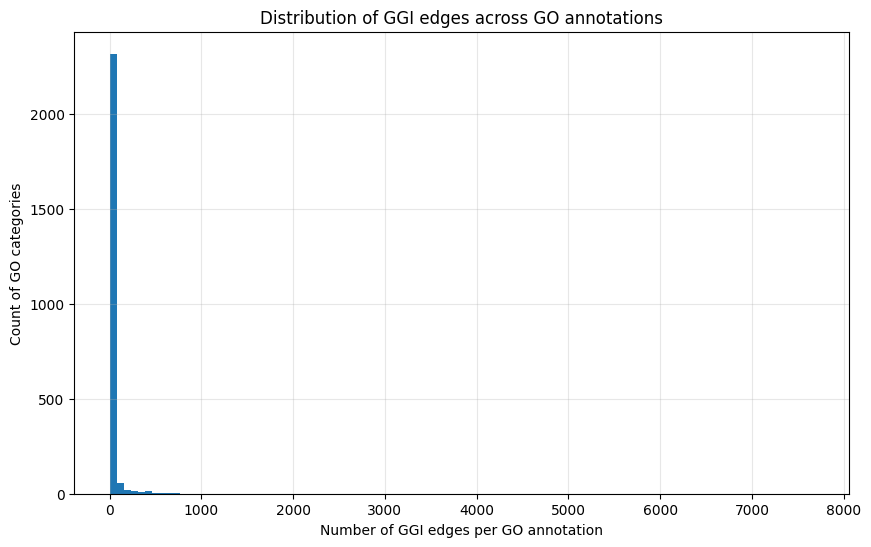

In [5]:
plt.figure(figsize=(10,6))
plt.hist(df["edge_count"], bins=100)
plt.xlabel("Number of GGI edges per GO annotation")
plt.ylabel("Count of GO categories")
plt.title("Distribution of GGI edges across GO annotations")
plt.grid(True, alpha=0.3)
plt.show()

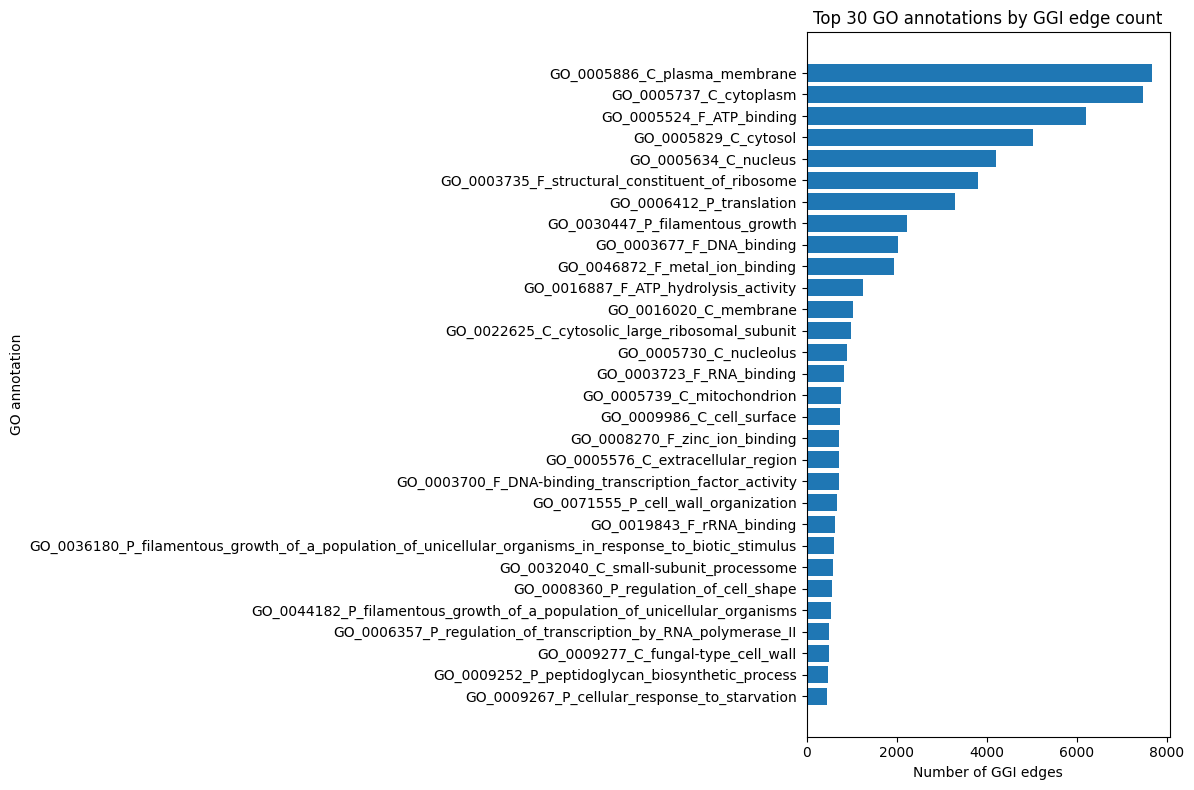

In [6]:
top_n = 30

plt.figure(figsize=(12,8))
plt.barh(df_sorted["GO_annotation"].head(top_n)[::-1],
         df_sorted["edge_count"].head(top_n)[::-1])
plt.xlabel("Number of GGI edges")
plt.ylabel("GO annotation")
plt.title(f"Top {top_n} GO annotations by GGI edge count")
plt.tight_layout()
plt.show()


GO annotations with edge_count > 100: 114


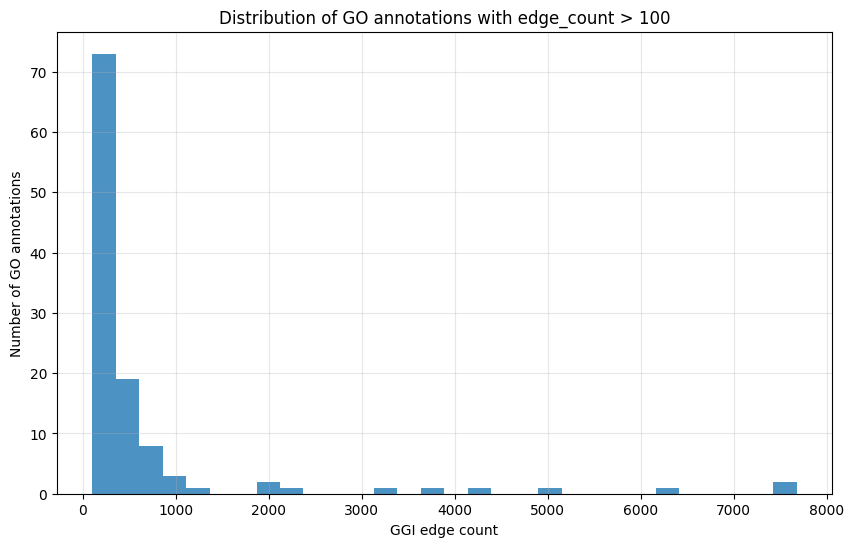

In [7]:
# ===== 设置阈值 =====
threshold = 100   # <<<<<<<<<<<<<< 你可以改成任意数，例如 100、200、500 等

df_high = df_sorted[df_sorted["edge_count"] > threshold]

print(f"GO annotations with edge_count > {threshold}: {len(df_high)}")

# ===== 绘制分布图（Histogram） =====
plt.figure(figsize=(10,6))
plt.hist(df_high["edge_count"], bins=30, alpha=0.8)
plt.xlabel("GGI edge count")
plt.ylabel("Number of GO annotations")
plt.title(f"Distribution of GO annotations with edge_count > {threshold}")
plt.grid(alpha=0.3)
plt.show()

In [8]:
# ===== 设置阈值 =====
threshold = 100   # <<<<<<<<<<< 你可以改成任意阈值

# ===== 计算数量 & 比例 =====
total = len(df)
low_count = (df["edge_count"] > threshold).sum()
ratio = low_count / total * 100

print(f"Total GO annotations: {total}")
print(f"GO annotations with edge_count > {threshold}: {low_count}")
print(f"Proportion: {ratio:.2f}%")

Total GO annotations: 2460
GO annotations with edge_count > 100: 114
Proportion: 4.63%


In [68]:
## 统计在不同 GO annotation 之间，比较它们的基因集合，并计算两两之间的交集

In [10]:
from pathlib import Path
import pandas as pd

GGI_DIR = Path("/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/data/5-network/ggi_edgelists")

go_to_genes = {}

for file in sorted(GGI_DIR.glob("*.txt")):
    go_ann = file.stem   # 文件名即 GO annotation

    genes = set()
    with file.open("r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                g1, g2 = parts[0], parts[1]
                genes.add(g1)
                genes.add(g2)

    go_to_genes[go_ann] = genes

print(f"Loaded {len(go_to_genes)} GO annotations with gene sets.")


Loaded 2460 GO annotations with gene sets.


In [2]:
# 计算 GO 之间的两两基因交集（Intersection）
import pandas as pd
import itertools

gos = list(go_to_genes.keys())

intersection_matrix = pd.DataFrame(0, index=gos, columns=gos)

for g1, g2 in itertools.combinations(gos, 2):
    inter = len(go_to_genes[g1] & go_to_genes[g2])
    intersection_matrix.loc[g1, g2] = inter
    intersection_matrix.loc[g2, g1] = inter

# 对角线填充为各自基因数
for g in gos:
    intersection_matrix.loc[g, g] = len(go_to_genes[g])

intersection_matrix.head()

GO_0000001_P_mitochondrion_inheritance  \
GO_0000001_P_mitochondrion_inheritance                                                   6   
GO_0000002_P_mitochondrial_genome_maintenance                                            0   
GO_0000009_F_alpha-1_6-mannosyltransferase_acti...                                       0   
GO_0000010_F_heptaprenyl_diphosphate_synthase_a...                                       0   
GO_0000011_P_vacuole_inheritance                                                         0   

                                                    GO_0000002_P_mitochondrial_genome_maintenance  \
GO_0000001_P_mitochondrion_inheritance                                                          0   
GO_0000002_P_mitochondrial_genome_maintenance                                                  14   
GO_0000009_F_alpha-1_6-mannosyltransferase_acti...                                              0   
GO_0000010_F_heptaprenyl_diphosphate_synthase_a...                                              0   
GO_0000011_P_vacuole_inheritance                                                                0   

                                                    GO_0000009_F_alpha-1_6-mannosyltransferase_activity  \
GO_0000001_P_mitochondrion_inheritance                                                              0     
GO_0000002_P_mitochondrial_genome_maintenance                                                       0     
GO_0000009_F_alpha-1_6-mannosyltransferase_acti...                                                  7     
GO_0000010_F_heptaprenyl_diphosphate_synthase_a...                                                  0     
GO_0000011_P_vacuole_inheritance                                                                    0     

                                                    GO_0000010_F_heptaprenyl_diphosphate_synthase_activity  \
GO_0000001_P_mitochondrion_inheritance                                                              0        
GO_0000002_P_mitochondrial_genome_maintenance                                                       0        
GO_0000009_F_alpha-1_6-mannosyltransferase_acti...                                                  0        
GO_0000010_F_heptaprenyl_diphosphate_synthase_a...                                                  2        
GO_0000011_P_vacuole_inheritance                                                                    0        

                                                    GO_0000011_P_vacuole_inheritance  \
GO_0000001_P_mitochondrion_inheritance                                             0   
GO_0000002_P_mitochondrial_genome_maintenance                                      0   
GO_0000009_F_alpha-1_6-mannosyltransferase_acti...                                 0   
GO_0000010_F_heptaprenyl_diphosphate_synthase_a...                                 0   
GO_0000011_P_vacuole_inheritance                                                   8   

                                                    GO_0000014_F_single-stranded_DNA_endodeoxyribonuclease_activity  \
GO_0000001_P_mitochondrion_inheritance                                                              0                 
GO_0000002_P_mitochondrial_genome_maintenance                                                       0                 
GO_0000009_F_alpha-1_6-mannosyltransferase_acti...                                                  0                 
GO_0000010_F_heptaprenyl_diphosphate_synthase_a...                                                  0                 
GO_0000011_P_vacuole_inheritance                                                                    0                 

                                                    GO_0000019_P_regulation_of_mitotic_recombination  \
GO_0000001_P_mitochondrion_inheritance                                                             0   
GO_0000002_P_mitochondrial_genome_maintenance                                                      0   
GO_0000009_F_alpha-1

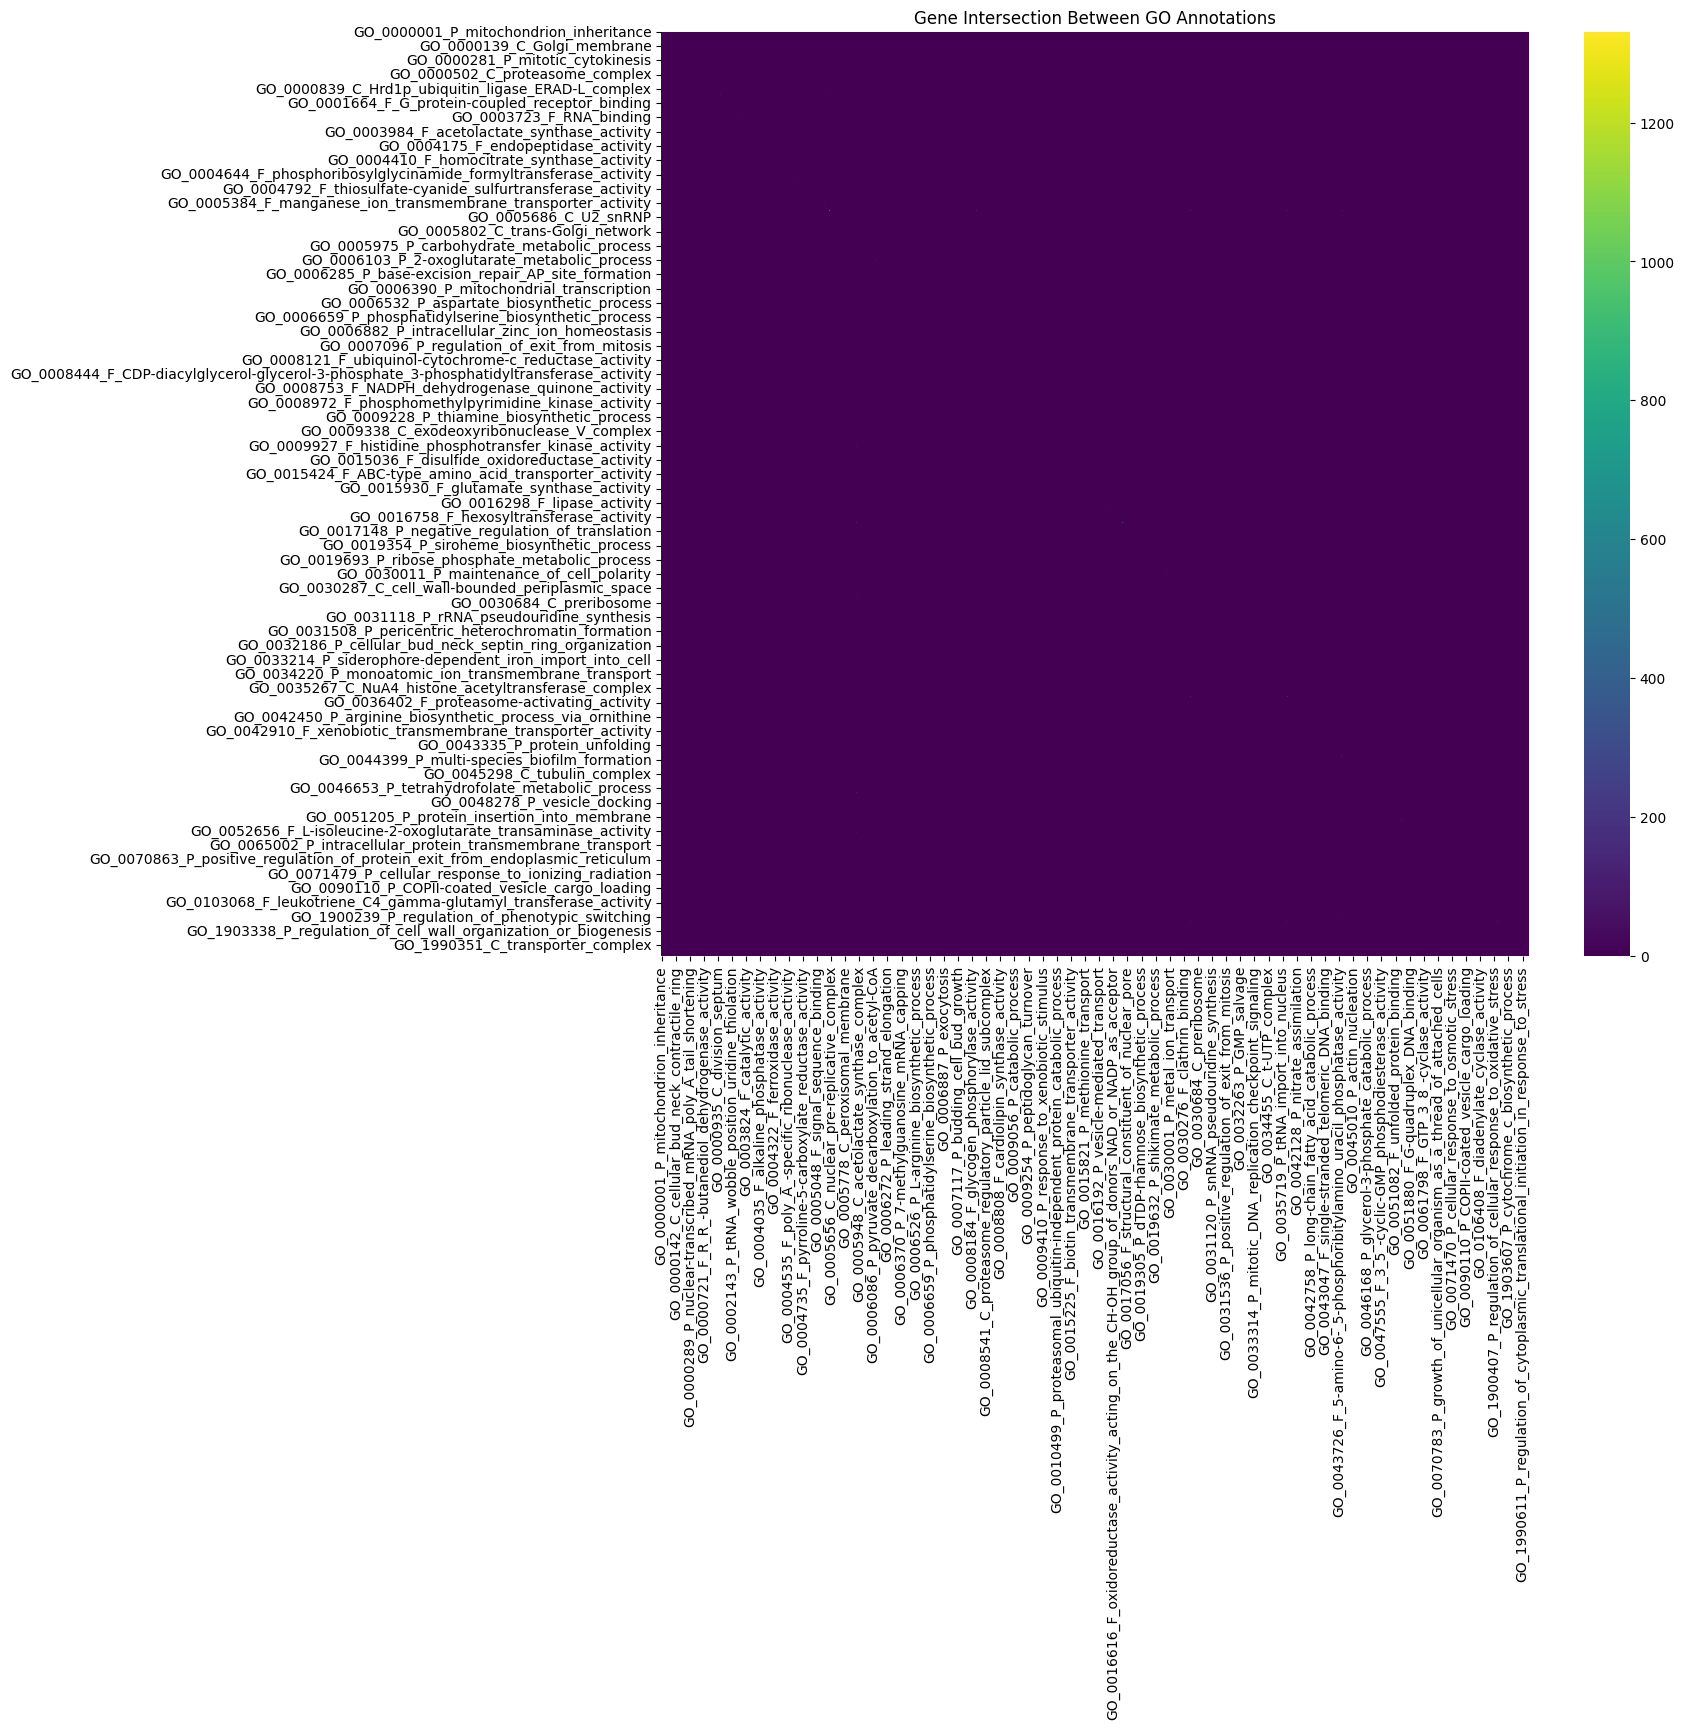

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))
sns.heatmap(intersection_matrix, cmap="viridis")
plt.title("Gene Intersection Between GO Annotations")
plt.show()

In [ ]:
N = 30
subset = intersection_matrix.iloc[:N, :N]

plt.figure(figsize=(12, 10))
sns.heatmap(subset, cmap="viridis")
plt.title(f"Top {N} GO annotations (by gene intersection)")
plt.show()

In [12]:
## 统计在不同 GO annotation 之间，比较它们的基因集合，并计算两两之间的交集
import pandas as pd
import itertools

# 所有 GO term
gos = list(go_to_genes.keys())

# 交集数量矩阵（可选，如果你还想保留“数量”）
intersection_matrix = pd.DataFrame(0, index=gos, columns=gos, dtype=int)

# 百分比矩阵（Jaccard，相似度）
percent_matrix = pd.DataFrame(0.0, index=gos, columns=gos)

for g1, g2 in itertools.combinations(gos, 2):
    genes1 = go_to_genes[g1]
    genes2 = go_to_genes[g2]
    
    inter = len(genes1 & genes2)            # 交集
    union = len(genes1 | genes2)            # 并集
    jaccard = inter / union if union > 0 else 0.0  # 交集占并集的比例

    # 填充交集数量矩阵
    intersection_matrix.loc[g1, g2] = inter
    intersection_matrix.loc[g2, g1] = inter

    # 填充百分比（对称）
    percent_matrix.loc[g1, g2] = jaccard
    percent_matrix.loc[g2, g1] = jaccard

# 对角线：自己和自己，交集 = 本身，Jaccard = 1
for g in gos:
    intersection_matrix.loc[g, g] = len(go_to_genes[g])
    percent_matrix.loc[g, g] = 1.0

# 看一下前几行
intersection_matrix.head()
percent_matrix.head()


GO_0000001_P_mitochondrion_inheritance  \
GO_0000001_P_mitochondrion_inheritance                                                 1.0   
GO_0000002_P_mitochondrial_genome_maintenance                                          0.0   
GO_0000009_F_alpha-1_6-mannosyltransferase_acti...                                     0.0   
GO_0000010_F_heptaprenyl_diphosphate_synthase_a...                                     0.0   
GO_0000011_P_vacuole_inheritance                                                       0.0   

                                                    GO_0000002_P_mitochondrial_genome_maintenance  \
GO_0000001_P_mitochondrion_inheritance                                                        0.0   
GO_0000002_P_mitochondrial_genome_maintenance                                                 1.0   
GO_0000009_F_alpha-1_6-mannosyltransferase_acti...                                            0.0   
GO_0000010_F_heptaprenyl_diphosphate_synthase_a...                                            0.0   
GO_0000011_P_vacuole_inheritance                                                              0.0   

                                                    GO_0000009_F_alpha-1_6-mannosyltransferase_activity  \
GO_0000001_P_mitochondrion_inheritance                                                            0.0     
GO_0000002_P_mitochondrial_genome_maintenance                                                     0.0     
GO_0000009_F_alpha-1_6-mannosyltransferase_acti...                                                1.0     
GO_0000010_F_heptaprenyl_diphosphate_synthase_a...                                                0.0     
GO_0000011_P_vacuole_inheritance                                                                  0.0     

                                                    GO_0000010_F_heptaprenyl_diphosphate_synthase_activity  \
GO_0000001_P_mitochondrion_inheritance                                                            0.0        
GO_0000002_P_mitochondrial_genome_maintenance                                                     0.0        
GO_0000009_F_alpha-1_6-mannosyltransferase_acti...                                                0.0        
GO_0000010_F_heptaprenyl_diphosphate_synthase_a...                                                1.0        
GO_0000011_P_vacuole_inheritance                                                                  0.0        

                                                    GO_0000011_P_vacuole_inheritance  \
GO_0000001_P_mitochondrion_inheritance                                           0.0   
GO_0000002_P_mitochondrial_genome_maintenance                                    0.0   
GO_0000009_F_alpha-1_6-mannosyltransferase_acti...                               0.0   
GO_0000010_F_heptaprenyl_diphosphate_synthase_a...                               0.0   
GO_0000011_P_vacuole_inheritance                                                 1.0   

                                                    GO_0000014_F_single-stranded_DNA_endodeoxyribonuclease_activity  \
GO_0000001_P_mitochondrion_inheritance                                                            0.0                 
GO_0000002_P_mitochondrial_genome_maintenance                                                     0.0                 
GO_0000009_F_alpha-1_6-mannosyltransferase_acti...                                                0.0                 
GO_0000010_F_heptaprenyl_diphosphate_synthase_a...                                                0.0                 
GO_0000011_P_vacuole_inheritance                                                                  0.0                 

                                                    GO_0000019_P_regulation_of_mitotic_recombination  \
GO_0000001_P_mitochondrion_inheritance                                                           0.0   
GO_0000002_P_mitochondrial_genome_maintenance                                                    0.0   
GO_0000009_F_alpha-1

In [13]:
percent_matrix_pct = percent_matrix * 100  # 单位：%

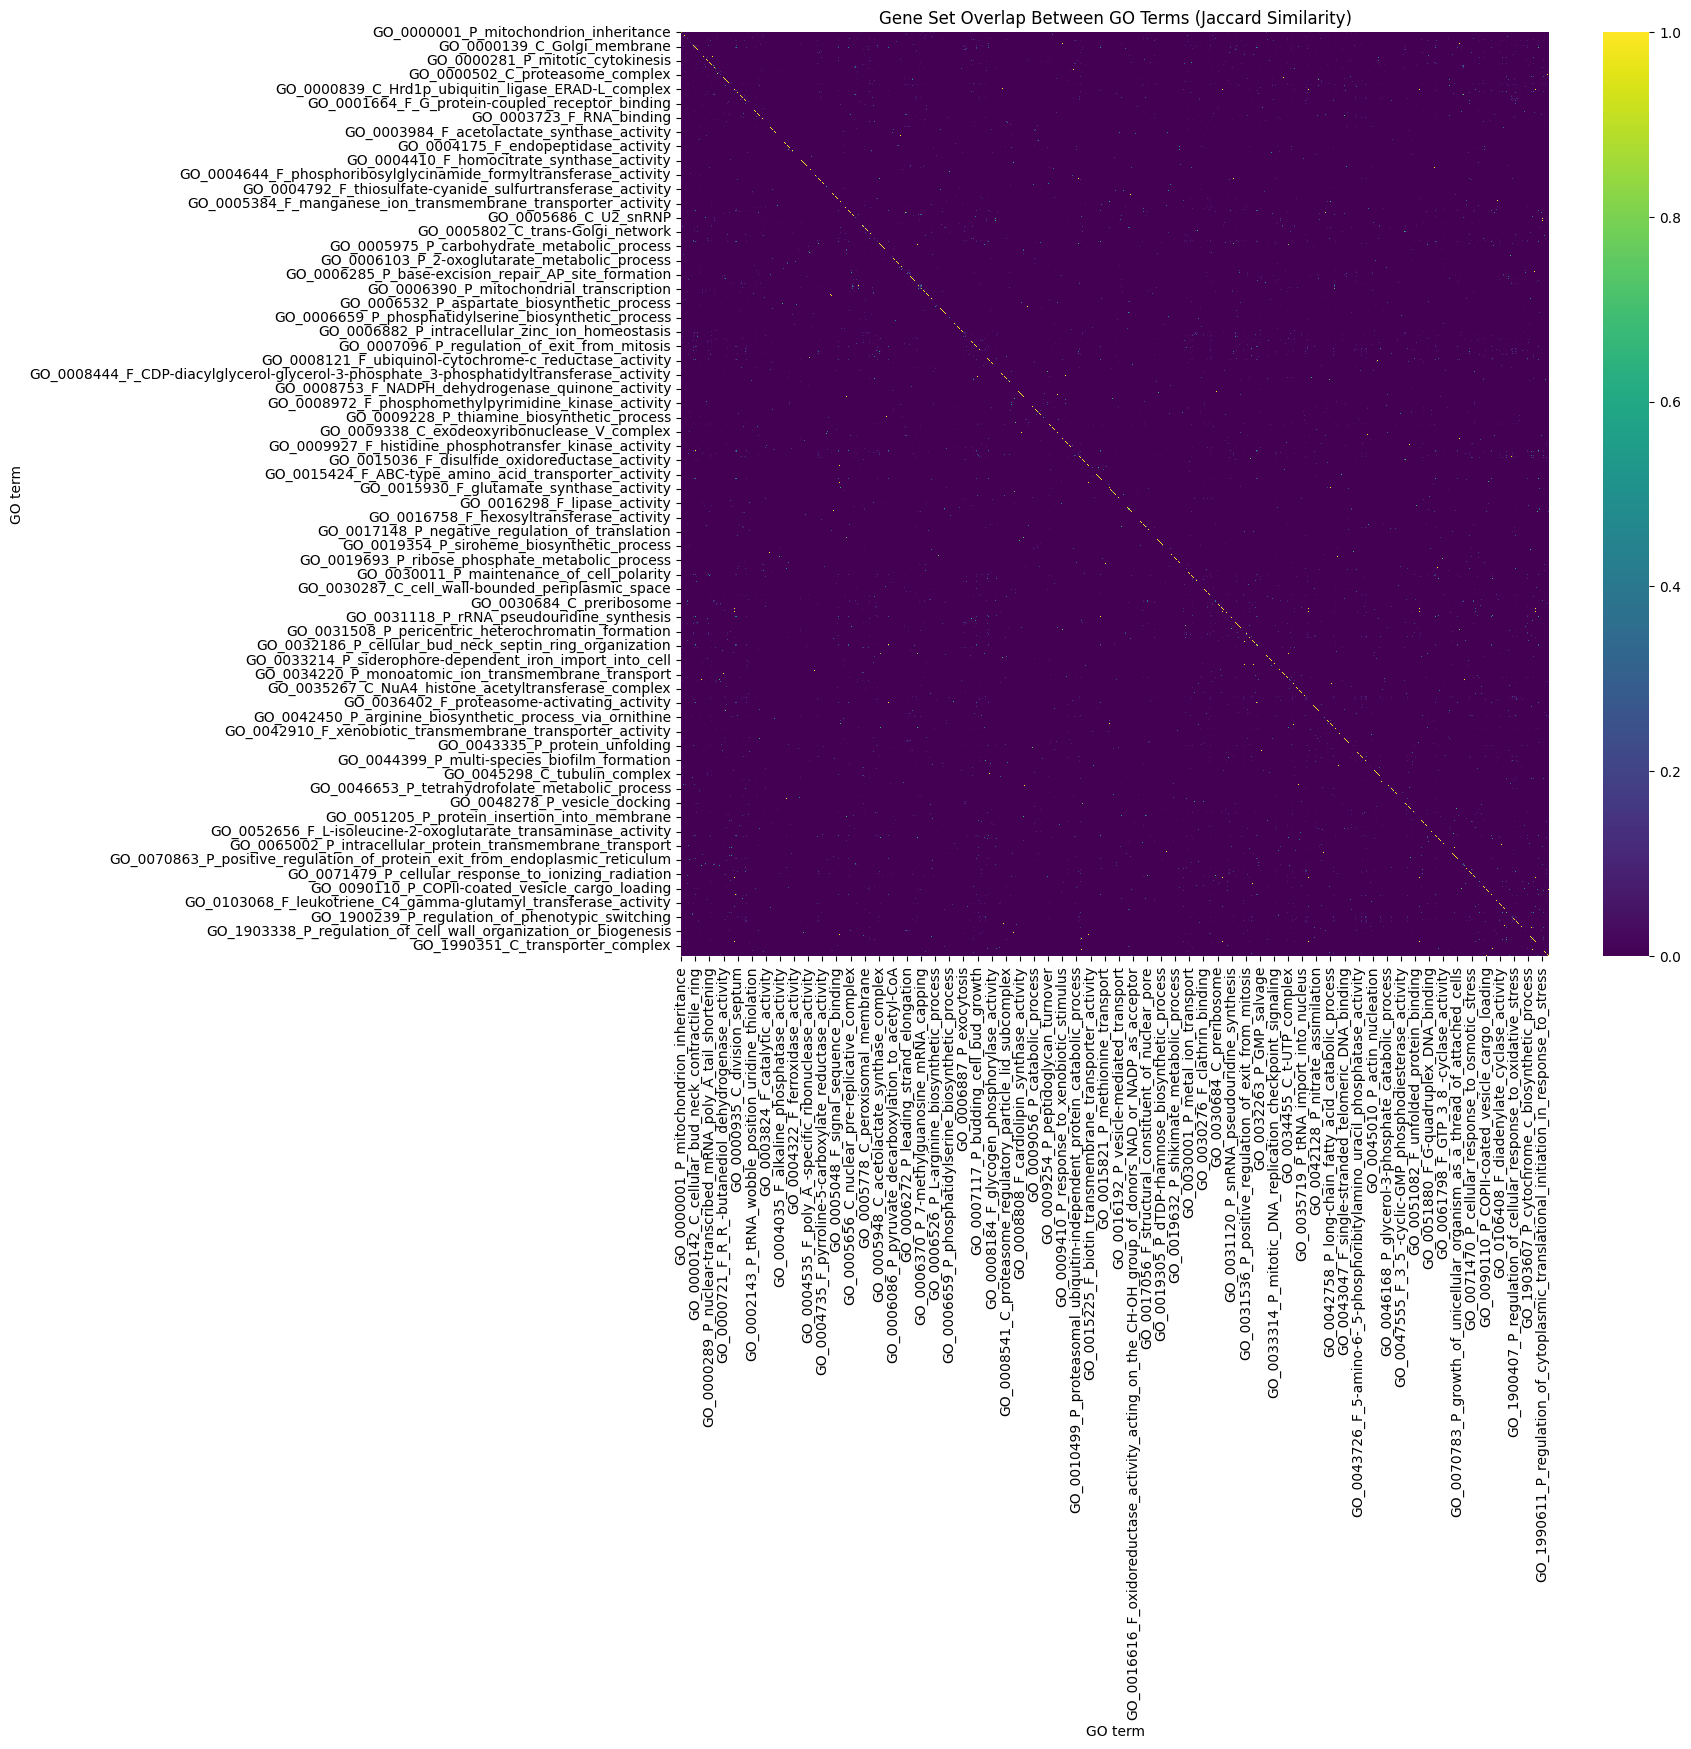

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))
sns.heatmap(percent_matrix, cmap="viridis")
plt.title("Gene Set Overlap Between GO Terms (Jaccard Similarity)")
plt.xlabel("GO term")
plt.ylabel("GO term")
plt.show()

In [ ]:
## 统计在不同 GO annotation 之间，比较它们的基因集合，并计算两两之间的交集
import pandas as pd
import itertools

# 所有 GO term
gos = list(go_to_genes.keys())

# 交集数量矩阵（可选，如果你还想保留“数量”）
intersection_matrix = pd.DataFrame(0, index=gos, columns=gos, dtype=int)

# 百分比矩阵（Jaccard，相似度）
percent_matrix = pd.DataFrame(0.0, index=gos, columns=gos)

for g1, g2 in itertools.combinations(gos, 2):
    genes1 = go_to_genes[g1]
    genes2 = go_to_genes[g2]
    
    inter = len(genes1 & genes2)            # 交集
    union = len(genes1 | genes2)            # 并集
    jaccard = inter / union if union > 0 else 0.0  # 交集占并集的比例

    # 填充交集数量矩阵
    intersection_matrix.loc[g1, g2] = inter
    intersection_matrix.loc[g2, g1] = inter

    # 填充百分比（对称）
    percent_matrix.loc[g1, g2] = jaccard
    percent_matrix.loc[g2, g1] = jaccard

# 对角线：自己和自己，交集 = 本身，Jaccard = 1
for g in gos:
    intersection_matrix.loc[g, g] = len(go_to_genes[g])
    percent_matrix.loc[g, g] = 1.0

# 看一下前几行
intersection_matrix.head()
percent_matrix.head()

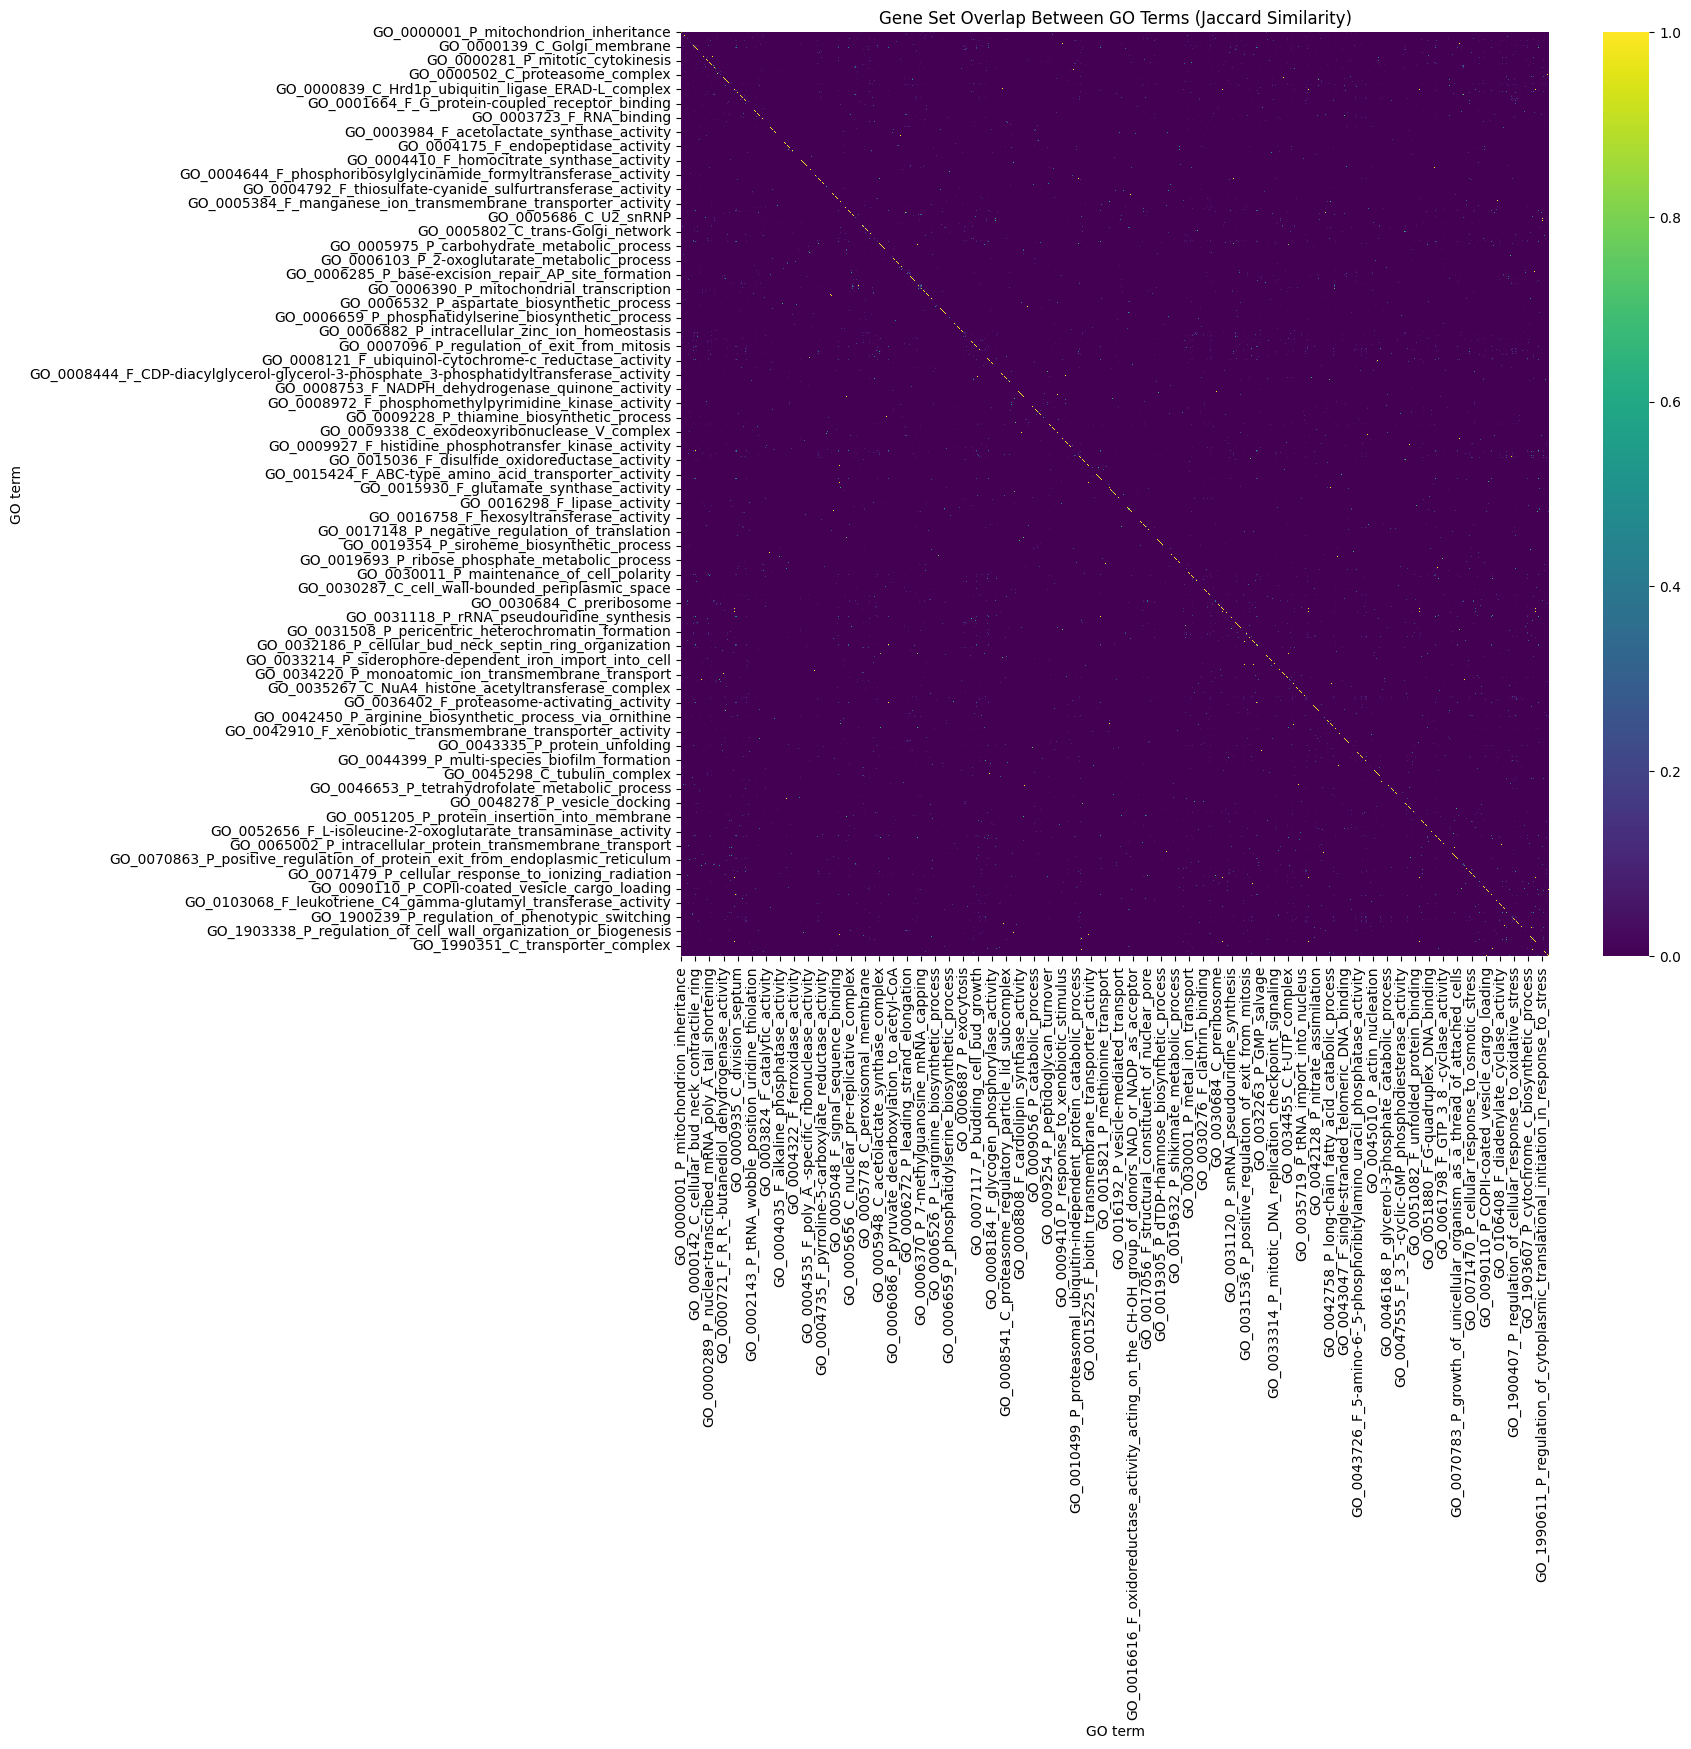

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))
sns.heatmap(percent_matrix, cmap="viridis")
plt.title("Gene Set Overlap Between GO Terms (Jaccard Similarity)")
plt.xlabel("GO term")
plt.ylabel("GO term")
plt.show()

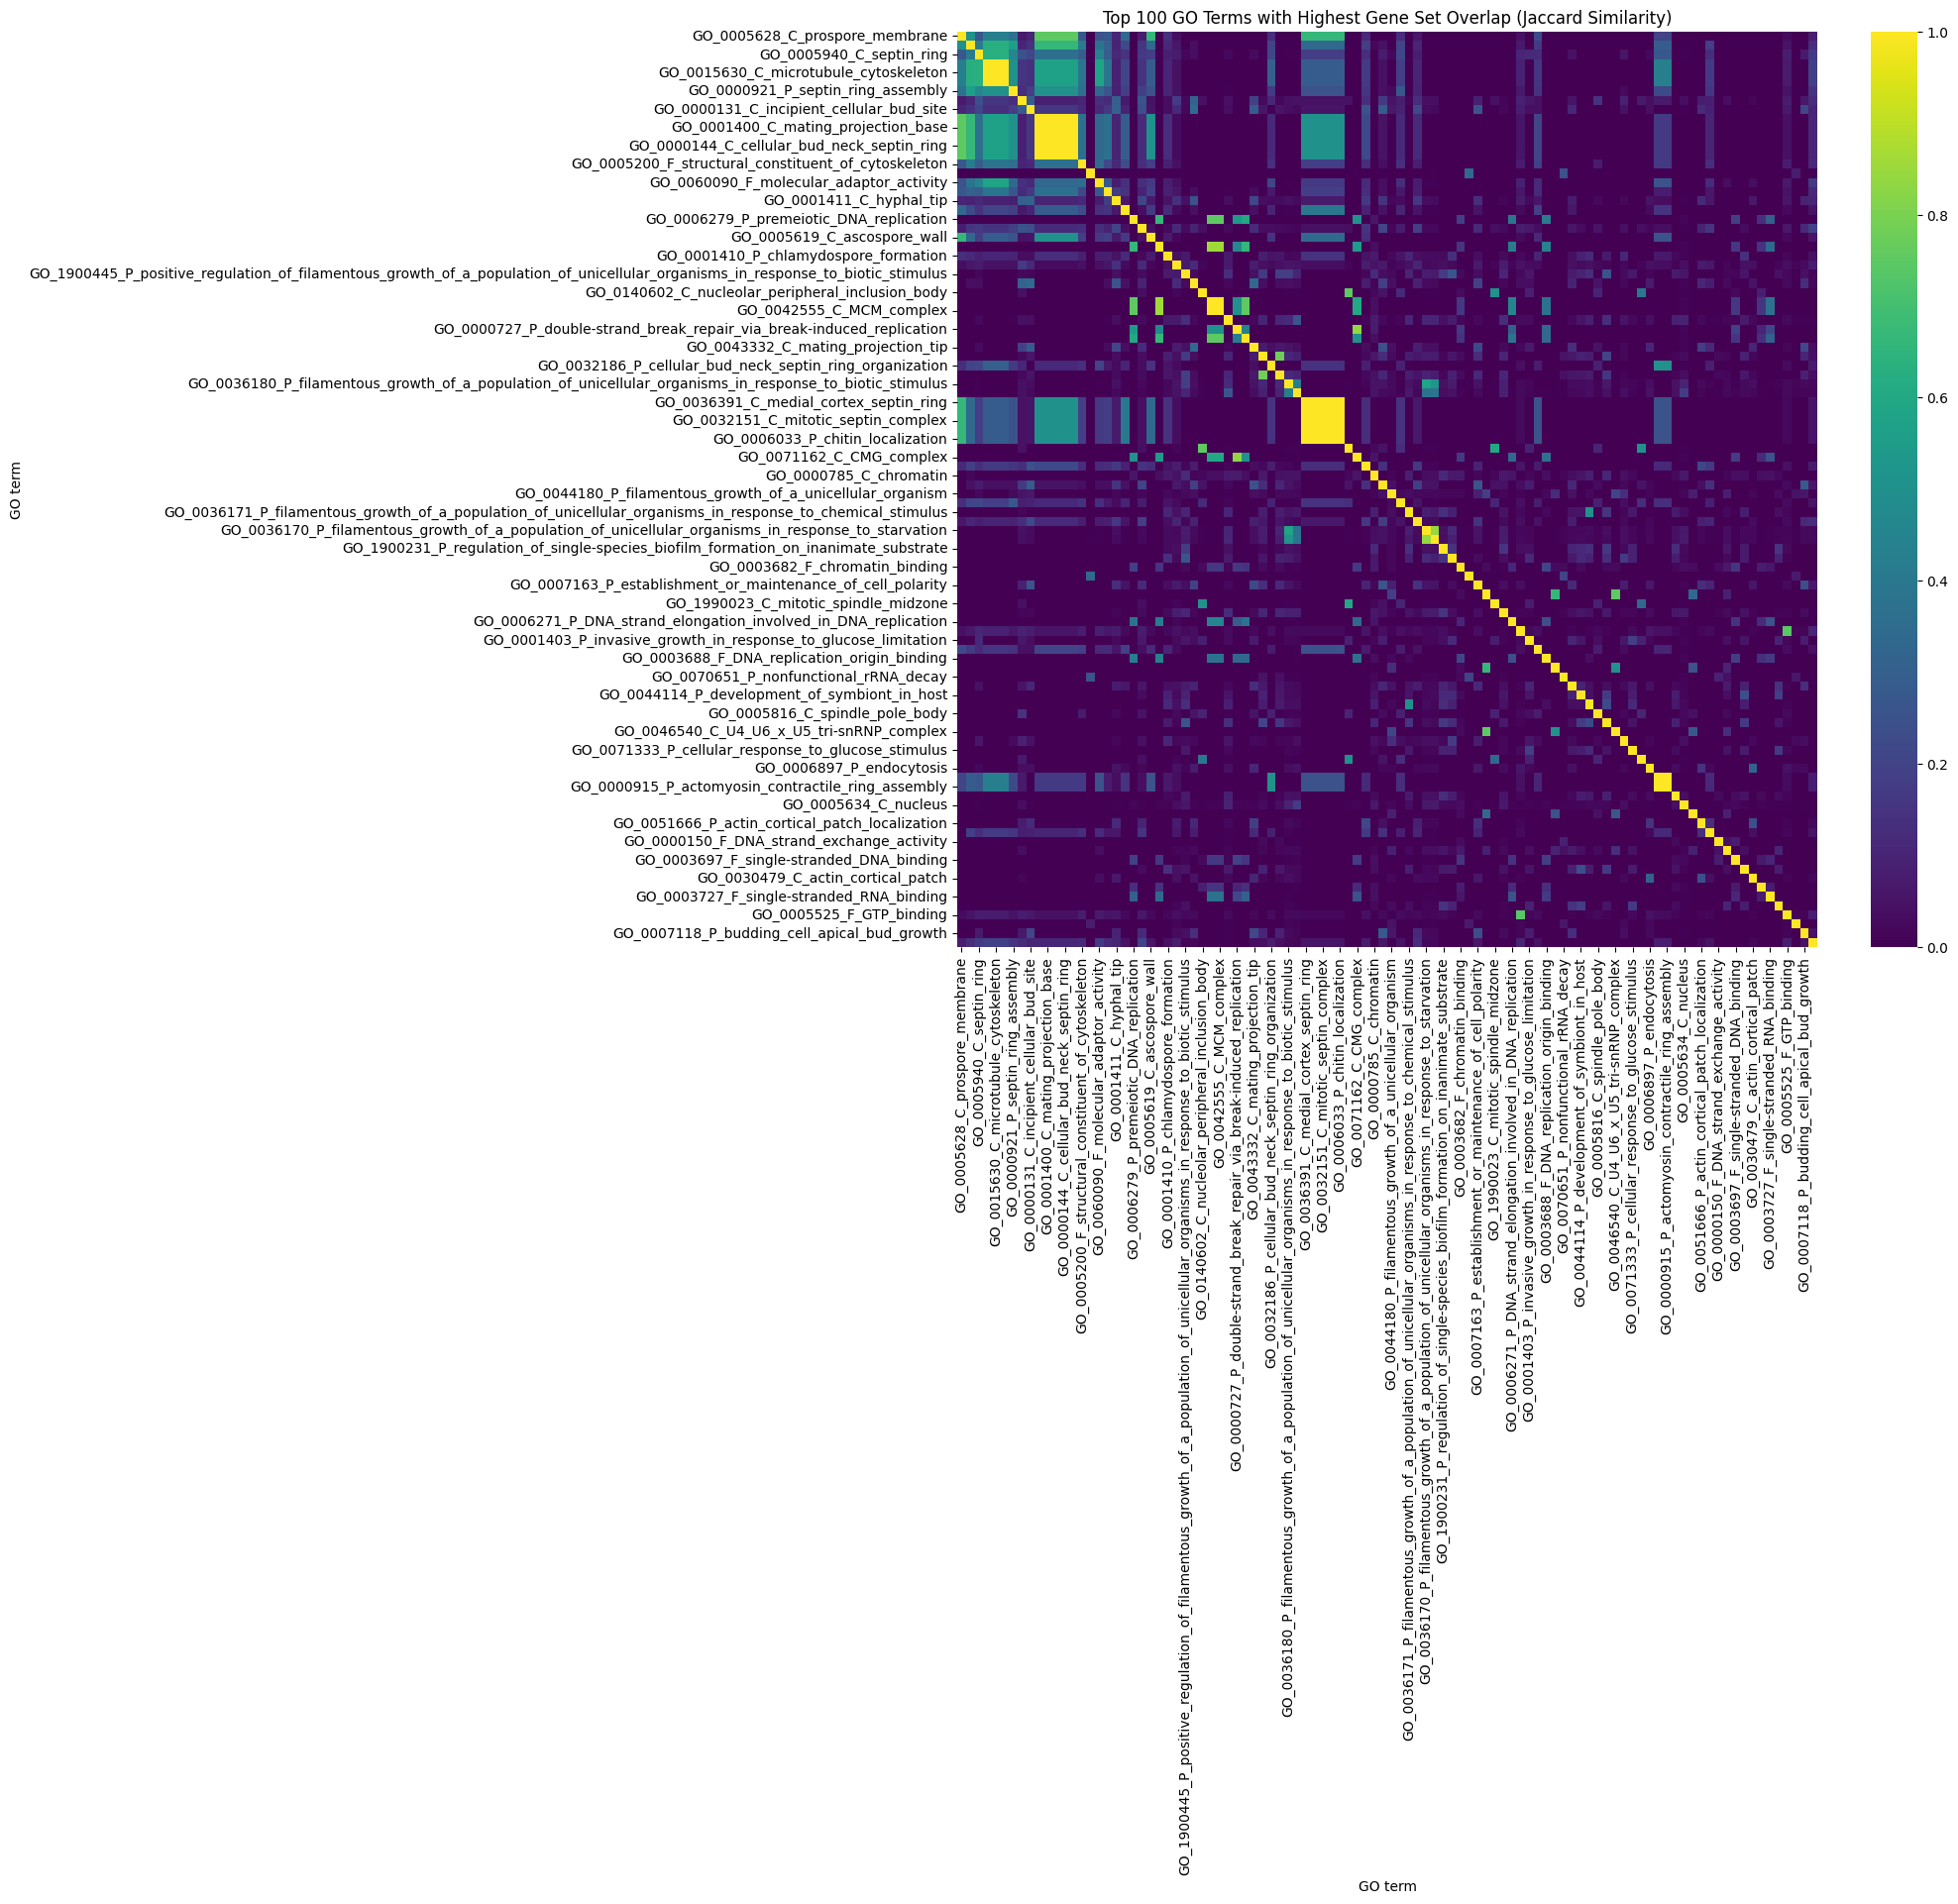

In [23]:
# 计算每个 GO 的平均相似度（排除自身）
mean_scores = percent_matrix.replace(1.0, 0).mean(axis=1)
topn = 100
# 选出平均相似度最高的 top30 GO
topn_gos = mean_scores.sort_values(ascending=False).head(topn).index

# 构建 top n 的子矩阵
percent_top = percent_matrix.loc[topn_gos, topn_gos]

# 绘图
plt.figure(figsize=(14, 12))
sns.heatmap(percent_top, cmap="viridis")
plt.title(f"Top {topn} GO Terms with Highest Gene Set Overlap (Jaccard Similarity)")
plt.xlabel("GO term")
plt.ylabel("GO term")
plt.show()

### Step 6. 统计每一个 GO annotation 下 gene 之间的连通性
___

In [39]:
import os
import pandas as pd
from tqdm import tqdm
import networkx as nx

ggi_dir = "/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/data/5-network/ggi_edgelists"
#ggi_dir = "/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/PINNACLE/data/networks/ppi_edgelists"

results = []

for file in tqdm(os.listdir(ggi_dir)):
    if not file.endswith(".txt"):
        continue

    go_id = file.replace(".txt", "")

    # 读取边
    df = pd.read_csv(os.path.join(ggi_dir, file), sep=r"\s+", header=None, names=["g1", "g2"])

    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_edge(row["g1"], row["g2"])

    # 计算连通性
    n = G.number_of_nodes()
    m = G.number_of_edges()

    if n > 1:
        density = nx.density(G)
    else:
        density = 0

    num_components = nx.number_connected_components(G)
    components = list(nx.connected_components(G))
    largest_comp = max(len(c) for c in components)

    avg_degree = sum(dict(G.degree()).values()) / n if n > 0 else 0
    clustering = nx.average_clustering(G) if n > 2 else 0

    is_clique = (m == n*(n-1)/2)

    results.append({
        "GO_ID": go_id,
        "n_genes": n,  # GO term 下基因的数量
        "n_edges": m,  # GO term 内部 gene–gene 互作数量
        "density": density,  # 衡量 GO 内部基因连接的“饱和程度”, ~ 1 之间，越接近 1 说明越接近完全图
        "n_components": num_components, # GO 内 gene network 被分成多少个独立块
        "largest_component": largest_comp, # GO 内最大功能子模块包含多少基因
        "avg_degree": avg_degree, # 衡量 GO 内网络的“活跃程度”与“核心紧密度”
        "clustering": clustering, # 衡量 GO 内部是否形成“紧密三角形结构”的功能模块
        "is_clique": is_clique  # 该 GO 是否是一个“所有基因互相连接”的完全功能模块
    })

results_df = pd.DataFrame(results)

100%|██████████| 2460/2460 [00:09<00:00, 261.14it/s]


In [40]:
#results_df.to_csv(f"panacea_go_ggi_state.csv", index=None)

In [41]:
results_df.sort_values(["n_genes","clustering"], ascending=False)

GO_ID  n_genes  n_edges  \
1189                       GO_0005886_C_plasma_membrane     1331     7678   
2151                             GO_0005737_C_cytoplasm     1122     7481   
2301                           GO_0005524_F_ATP_binding      838     6212   
1453                               GO_0005829_C_cytosol      798     5019   
1089                     GO_0046872_F_metal_ion_binding      591     1948   
...                                                 ...      ...      ...   
2446                             GO_0030894_C_replisome        2        1   
2447  GO_0016239_P_positive_regulation_of_macroautop...        2        1   
2449  GO_0004128_F_cytochrome-b5_reductase_activity_...        2        1   
2452       GO_0098797_C_plasma_membrane_protein_complex        2        1   
2454  GO_0042800_F_histone_H3K4_methyltransferase_ac...        2        1   

       density  n_components  largest_component  avg_degree  clustering  \
1189  0.008675             7                913   11.537190    0.376018   
2151  0.011896             4                649   13.335116    0.319242   
2301  0.017713             3                507   14.825776    0.364701   
1453  0.015783             5                513   12.578947    0.327267   
1089  0.011173            13                394    6.592217    0.286007   
...        ...           ...                ...         ...         ...   
2446  1.000000             1                  2    1.000000    0.000000   
2447  1.000000             1                  2    1.000000    0.000000   
2449  1.000000             1                  2    1.000000    0.000000   
2452  1.000000             1                  2    1.000000    0.000000   
2454  1.000000             1                  2    1.000000    0.000000   

      is_clique  
1189      False  
2151      False  
2301      False  
1453      False  
1089      False  
...         ...  
2446       True  
2447       True  
2449       True  
2452       True  
2454       True  

[2460 rows x 9 columns]

In [42]:
results_df[results_df['n_components'] == 1].sort_values(["n_genes","clustering"], ascending=False)

GO_ID  n_genes  n_edges  \
199                                GO_0005634_C_nucleus      547     4210   
80    GO_0006357_P_regulation_of_transcription_by_RN...      106      493   
516   GO_0000981_F_DNA-binding_transcription_factor_...       97      315   
2450                      GO_0098552_C_side_of_membrane       86      430   
1913                      GO_0030446_C_hyphal_cell_wall       70      339   
...                                                 ...      ...      ...   
2446                             GO_0030894_C_replisome        2        1   
2447  GO_0016239_P_positive_regulation_of_macroautop...        2        1   
2449  GO_0004128_F_cytochrome-b5_reductase_activity_...        2        1   
2452       GO_0098797_C_plasma_membrane_protein_complex        2        1   
2454  GO_0042800_F_histone_H3K4_methyltransferase_ac...        2        1   

       density  n_components  largest_component  avg_degree  clustering  \
199   0.028192             1                547   15.393053    0.338031   
80    0.088589             1                106    9.301887    0.541689   
516   0.067655             1                 97    6.494845    0.383983   
2450  0.117647             1                 86   10.000000    0.427430   
1913  0.140373             1                 70    9.685714    0.586835   
...        ...           ...                ...         ...         ...   
2446  1.000000             1                  2    1.000000    0.000000   
2447  1.000000             1                  2    1.000000    0.000000   
2449  1.000000             1                  2    1.000000    0.000000   
2452  1.000000             1                  2    1.000000    0.000000   
2454  1.000000             1                  2    1.000000    0.000000   

      is_clique  
199       False  
80        False  
516       False  
2450      False  
1913      False  
...         ...  
2446       True  
2447       True  
2449       True  
2452       True  
2454       True  

[1823 rows x 9 columns]

GO file: GO_0030446_C_hyphal_cell_wall.txt
#genes: 70, #edges: 339


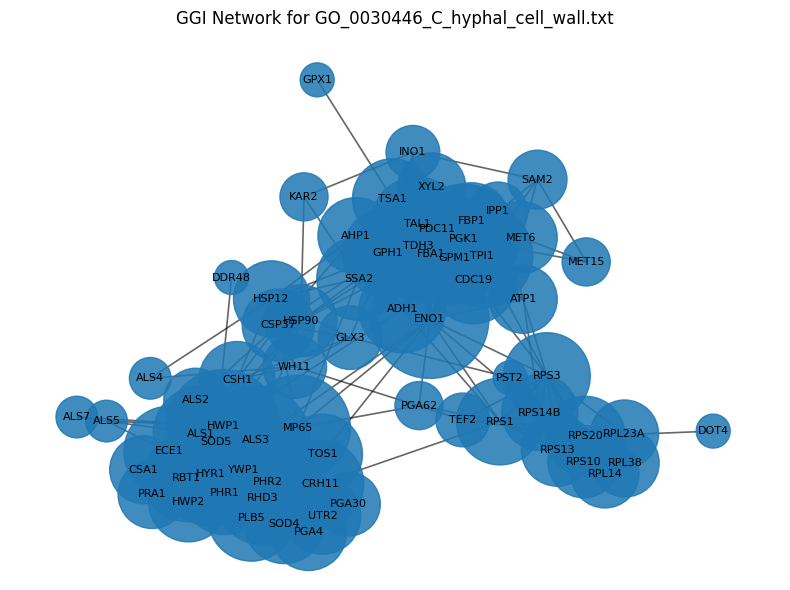

In [44]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ===== 1. 基本路径 & 选择一个 GO 文件 =====
ggi_dir = "/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/data/5-network/ggi_edgelists"
#ggi_dir = "/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/PINNACLE/data/networks/ppi_edgelists"

# 手动指定一个 GO 文件名（你也可以换成任意一个）
go_filename = "GO_0030446_C_hyphal_cell_wall.txt"
go_path = os.path.join(ggi_dir, go_filename)

# 如果你想随机选一个 GO 文件，可以用这句替代 ↑：
# import random
# go_filename = random.choice([f for f in os.listdir(ggi_dir) if f.endswith(".txt")])
# go_path = os.path.join(ggi_dir, go_filename)
# print("Selected GO file:", go_filename)

# ===== 2. 读取 GGI 边信息，构建网络 =====
df = pd.read_csv(go_path, sep=r"\s+", header=None, names=["gene1", "gene2"])

G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row["gene1"], row["gene2"])

print(f"GO file: {go_filename}")
print(f"#genes: {G.number_of_nodes()}, #edges: {G.number_of_edges()}")

# ===== 3. 计算布局（spring_layout 比较适合看关联性） =====
# 你也可以尝试 kamada_kawai_layout, circular_layout 等
pos = nx.spring_layout(G, k=0.8, iterations=100)

# 节点大小按 degree 映射，这样 hub 会更明显
degrees = dict(G.degree())
node_sizes = [ (degrees[n] + 1) * 300 for n in G.nodes() ]

# ===== 4. 画图 =====
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       alpha=0.85)
nx.draw_networkx_edges(G, pos,
                       width=1.2,
                       alpha=0.6)
nx.draw_networkx_labels(G, pos,
                        font_size=8)

plt.title(f"GGI Network for {go_filename}", fontsize=12)
plt.axis("off")
plt.tight_layout()
plt.show()

In [45]:
# 加载 GO annotation → strain → gene 信息
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from collections import defaultdict

GO_ROOT = Path("/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/data/4-go_annotation")

# go_ann → strain → set(genes)
go_to_strain_genes = defaultdict(lambda: defaultdict(set))

strain_dirs = [p for p in GO_ROOT.iterdir() if p.is_dir()]

for strain_dir in tqdm(strain_dirs):
    strain_name = strain_dir.name

    go_file = next(strain_dir.glob("*.go_raw.tsv"), None)
    if go_file is None:
        continue

    df = pd.read_csv(go_file, sep="\t", dtype=str).fillna("")
    if not {"Genes", "GO_ID", "GO_Type"}.issubset(df.columns):
        continue

    for _, row in df.iterrows():
        gene = row["Genes"].strip()
        go_id = row["GO_ID"].strip()
        go_type = row["GO_Type"].strip()

        if not gene or not go_id or not go_type:
            continue

        go_ann = f"{go_id}_{go_type}"
        go_to_strain_genes[go_ann][strain_name].add(gene)

print(f"Loaded GO annotation across {len(strain_dirs)} strains.")


Loaded GO annotation across 100 strains.


In [48]:
# 加载每个菌株的 GGI 网络（内部互作，不跨菌株）
GGI_ROOT = Path("/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/data/3-string_ppi_data")

# strain → set((geneA, geneB))
strain_to_ggi = defaultdict(set)

def find_ggi_file(strain_name):
    # 1）strain 子目录
    p1 = GGI_ROOT / strain_name / f"{strain_name}.ggi.in_genes.tsv"
    if p1.exists():
        return p1

    # 2）strain 子目录中任意 .ggi.in_genes.tsv
    p2 = list((GGI_ROOT / strain_name).glob("*.ggi.in_genes.tsv"))
    if p2:
        return p2[0]

    # 3）根目录
    p3 = GGI_ROOT / f"{strain_name}.ggi.in_genes.tsv"
    if p3.exists():
        return p3

    # 兜底
    cands = [p for p in GGI_ROOT.glob("*.ggi.in_genes.tsv") if strain_name in p.name]
    return cands[0] if cands else None


for strain_dir in tqdm(strain_dirs):
    strain_name = strain_dir.name
    ggi_file = find_ggi_file(strain_name)

    if ggi_file is None:
        continue

    df = pd.read_csv(ggi_file, sep="\t", dtype=str).fillna("")
    if not {"gene1", "gene2"}.issubset(df.columns):
        continue

    edges = set()
    for _, row in df.iterrows():
        g1 = row["gene1"].strip()
        g2 = row["gene2"].strip()
        if g1 and g2:
            a, b = sorted((g1, g2))
            edges.add((a, b))

    strain_to_ggi[strain_name] = edges

print(f"Loaded GGI networks for {len(strain_to_ggi)} strains.")

Loaded GGI networks for 100 strains.


In [53]:
results = []

for go_ann, strain_genes in tqdm(go_to_strain_genes.items()):

    # GO 必须在 >= 2 个菌株中出现
    if len(strain_genes) < 2:
        continue
        
    # 对每个菌株检查：
    # strain 内部的基因是否有 GGI 边？
    strain_has_interaction = {}

    for strain, genes in strain_genes.items():
        ggi_edges = strain_to_ggi.get(strain, set())

        # 求 strain 内部的 gene–gene 是否有边
        any_interaction = False
        for a, b in ggi_edges:
            if a in genes and b in genes:
                any_interaction = True
                break

        strain_has_interaction[strain] = any_interaction

    # 如果所有菌株都没有内部 GGI，则记录下来
    if not any(strain_has_interaction.values()):
        results.append((go_ann, strain_genes, strain_has_interaction))

print(f"GO annotations shared by multiple strains but NO internal GGI: {len(results)}")

100%|██████████| 6007/6007 [05:45<00:00, 17.39it/s]  

GO annotations shared by multiple strains but NO internal GGI: 1614


In [56]:
from collections import defaultdict

# strain → set(出现在任意 GGI edge 中的 gene)
strain_to_ggi_nodes = {}

for strain, edges in strain_to_ggi.items():
    nodes = set()
    for a, b in edges:
        nodes.add(a)
        nodes.add(b)
    strain_to_ggi_nodes[strain] = nodes

print(f"Built GGI node sets for {len(strain_to_ggi_nodes)} strains.")


Built GGI node sets for 100 strains.


In [58]:
import pandas as pd

summary_rows = []

for go_ann, strain_genes, strain_has_interaction in results:
    total_genes = 0
    genes_with_ggi = 0
    genes_without_ggi = 0

    for strain, genes in strain_genes.items():
        ggi_nodes = strain_to_ggi_nodes.get(strain, set())
        for g in genes:
            total_genes += 1
            if g in ggi_nodes:
                genes_with_ggi += 1
            else:
                genes_without_ggi += 1

    summary_rows.append({
        "GO_annotation": go_ann,
        "n_total_genes": total_genes,
        "n_genes_with_any_GGI": genes_with_ggi,
        "n_genes_without_GGI": genes_without_ggi,
        "prop_with_any_GGI": genes_with_ggi / total_genes if total_genes > 0 else 0.0
    })

df_go_gene_ggi = pd.DataFrame(summary_rows).sort_values("n_total_genes", ascending=False)
df_go_gene_ggi.head(20)


GO_annotation  n_total_genes  \
9                      GO:0050897_F:cobalt ion binding            134   
13        GO:0051259_P:protein complex oligomerization            123   
87           GO:0006424_P:glutamyl-tRNA aminoacylation            113   
59           GO:0043043_P:peptide biosynthetic process            113   
43                       GO:0009409_P:response to cold            110   
145  GO:0019897_C:extrinsic component of plasma mem...            110   
80            GO:0004615_F:phosphomannomutase activity            107   
68     GO:0004150_F:dihydroneopterin aldolase activity            106   
73    GO:0005047_F:signal recognition particle binding            105   
28   GO:0015190_F:L-leucine transmembrane transport...            103   
61     GO:0004634_F:phosphopyruvate hydratase activity            100   
33         GO:0006107_P:oxaloacetate metabolic process             99   
85               GO:0004370_F:glycerol kinase activity             98   
107    GO:0045727_P:positive regulation of translation             98   
109  GO:0004148_F:dihydrolipoyl dehydrogenase (NADH...             97   
92                  GO:0003921_F:GMP synthase activity             97   
16            GO:0006420_P:arginyl-tRNA aminoacylation             96   
15          GO:0004814_F:arginine-tRNA ligase activity             96   
7              GO:0006419_P:alanyl-tRNA aminoacylation             96   
6            GO:0004813_F:alanine-tRNA ligase activity             96   

     n_genes_with_any_GGI  n_genes_without_GGI  prop_with_any_GGI  
9                     134                    0                1.0  
13                    123                    0                1.0  
87                    113                    0                1.0  
59                    113                    0                1.0  
43                    110                    0                1.0  
145                   110                    0                1.0  
80                    107                    0                1.0  
68                    106                    0                1.0  
73                    105                    0                1.0  
28                    103                    0                1.0  
61                    100                    0                1.0  
33                     99                    0                1.0  
85                     98                    0                1.0  
107                    98                    0                1.0  
109                    97                    0                1.0  
92                     97                    0                1.0  
16                     96                    0                1.0  
15                     96                    0                1.0  
7                      96                    0                1.0  
6                      96                    0                1.0

In [60]:
target_go = "GO:0050897_F:cobalt ion binding"

for go_ann, strain_genes, strain_has_interaction in results:
    if go_ann != target_go:
        continue

    print("GO:", go_ann)
    for strain, genes in strain_genes.items():
        ggi_nodes = strain_to_ggi_nodes.get(strain, set())
        for g in genes:
            flag = "WITH_GGI" if g in ggi_nodes else "NO_GGI"
            print(f"  {strain:40s}  {g:20s}  {flag}")

GO: GO:0050897_F:cobalt ion binding
  Enterococcus_faecalis_12-1VP              allB                  WITH_GGI
  Escherichia_coli_BW25113                  allB                  WITH_GGI
  Escherichia_coli_BW25113                  dapE                  WITH_GGI
  Escherichia_coli_BW25113                  ydaN                  WITH_GGI
  Escherichia_coli_BW25113                  pdxA                  WITH_GGI
  Escherichia_coli_ATCC_9637                allB                  WITH_GGI
  Escherichia_coli_ATCC_9637                dapE                  WITH_GGI
  Escherichia_coli_ATCC_9637                ydaN                  WITH_GGI
  Escherichia_coli_ATCC_9637                pdxA                  WITH_GGI
  Enterococcus_faecalis_10-1-04             allB                  WITH_GGI
  Acinetobacter_baumannii_TP1               pdxA                  WITH_GGI
  Enterococcus_faecalis_13-2-16             allB                  WITH_GGI
  Enterococcus_faecalis_10-6-50             allB                